# Regularização

Este notebook apresenta as principais técnicas de regularização utilizadas em deep learning para combater o overfitting e melhorar a generalização dos modelos. Abordaremos a implementação prática usando PyTorch.

## Conteúdos Abordados

1. **Introdução ao Overfitting**: Compreendendo o problema
2. **Dropout**: Regularização através de desativação aleatória
3. **Penalidades de Peso (L1 e L2)**: Weight decay e sparsidade
4. **Early Stopping**: Parada antecipada baseada na validação
5. **Data Augmentation**: Aumentando a diversidade dos dados
6. **Comparação das Técnicas**: Análise experimental

## Setup e Preparação dos Dados

Começamos importando as bibliotecas necessárias e preparando um dataset reduzido do MNIST para experimentos rápidos.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import copy

# Configurações
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

Usando dispositivo: cpu


In [ ]:
# Preparação do dataset MNIST reduzido
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset completo
full_train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
full_test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

# Criando subsets reduzidos para experimentos rápidos
train_indices = torch.randperm(len(full_train_dataset))[:4000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_test_dataset, val_indices)

print(f"Dataset de treino: {len(train_dataset)} amostras")
print(f"Dataset de validação: {len(val_dataset)} amostras")

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 758kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.9MB/s]

Dataset de treino: 4000 amostras
Dataset de validação: 1000 amostras


## 1. Introdução ao Overfitting

O **overfitting** ocorre quando um modelo aprende muito bem os dados de treinamento, incluindo o ruído e padrões específicos desses dados, mas falha em generalizar para dados novos. Matematicamente, isso acontece quando a complexidade do modelo é muito alta em relação à quantidade de dados disponíveis.

O **bias-variance tradeoff** é fundamental para entender este fenômeno:

$$\text{Erro Total} = \text{Bias}^2 + \text{Variance} + \text{Ruído Irredutível}$$

- **Bias**: erro devido a suposições simplificadoras no algoritmo
- **Variance**: erro devido à sensibilidade a pequenas flutuações nos dados de treino
- **Ruído Irredutível**: erro inerente ao problema

In [ ]:
# Modelo base simples para demonstrar overfitting
class BaseModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    """Função geral de treinamento"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def evaluate_model(model, data_loader):
    """Função de avaliação do modelo"""
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)

    return accuracy, avg_loss

### Experimento Baseline: Modelo sem Regularização

Primeiro, vamos treinar um modelo sem nenhuma técnica de regularização para estabelecer uma baseline e observar o comportamento do overfitting.

Treinando modelo baseline (sem regularização)...
Época [5/30] - Train Loss: 0.1278, Train Acc: 95.92% - Val Loss: 0.2266, Val Acc: 93.20%
Época [10/30] - Train Loss: 0.0169, Train Acc: 99.72% - Val Loss: 0.2319, Val Acc: 93.60%
Época [15/30] - Train Loss: 0.0022, Train Acc: 100.00% - Val Loss: 0.2342, Val Acc: 93.90%
Época [20/30] - Train Loss: 0.0011, Train Acc: 100.00% - Val Loss: 0.2466, Val Acc: 93.60%
Época [25/30] - Train Loss: 0.0007, Train Acc: 100.00% - Val Loss: 0.2572, Val Acc: 93.60%
Época [30/30] - Train Loss: 0.0004, Train Acc: 100.00% - Val Loss: 0.2629, Val Acc: 93.60%


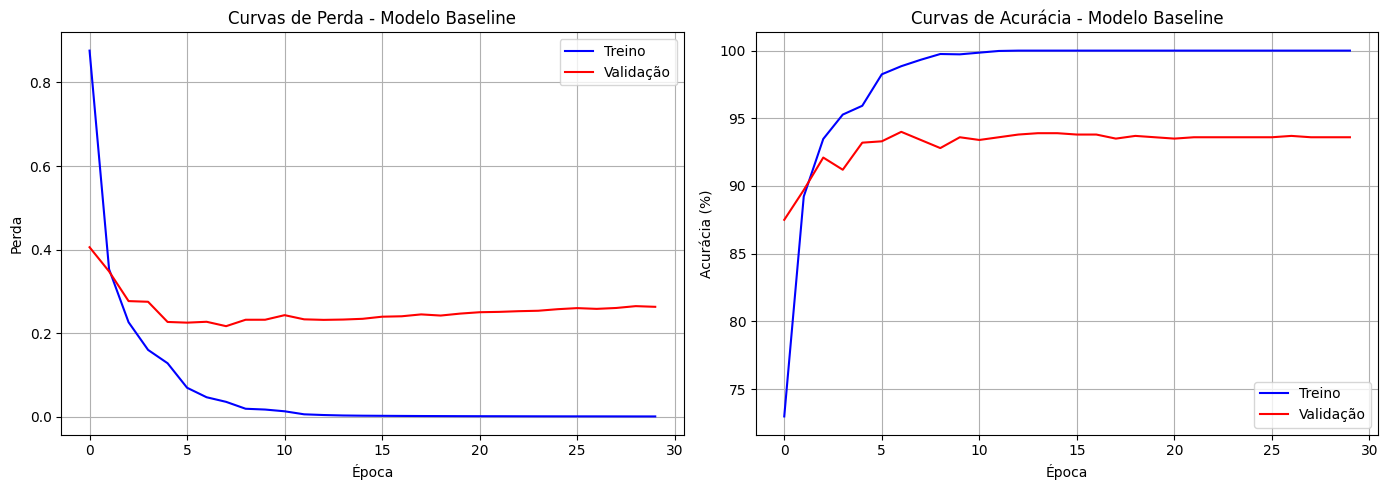


Desempenho final do modelo baseline:
Acurácia de validação: 93.60%
Perda de validação: 0.2629


In [ ]:
# Modelo baseline sem regularização
baseline_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

print("Treinando modelo baseline (sem regularização)...")
baseline_train_losses, baseline_val_losses, baseline_train_acc, baseline_val_acc = train_model(
    baseline_model, train_loader, val_loader, criterion, optimizer, num_epochs=30
)

# Plotar curvas de aprendizado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Perda
ax1.plot(baseline_train_losses, label='Treino', color='blue')
ax1.plot(baseline_val_losses, label='Validação', color='red')
ax1.set_title('Curvas de Perda - Modelo Baseline')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Acurácia
ax2.plot(baseline_train_acc, label='Treino', color='blue')
ax2.plot(baseline_val_acc, label='Validação', color='red')
ax2.set_title('Curvas de Acurácia - Modelo Baseline')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

baseline_val_acc_final, baseline_val_loss_final = evaluate_model(baseline_model, val_loader)
print(f"\nDesempenho final do modelo baseline:")
print(f"Acurácia de validação: {baseline_val_acc_final:.2f}%")
print(f"Perda de validação: {baseline_val_loss_final:.4f}")

## 2. Dropout

O **Dropout** é uma técnica de regularização que, durante o treinamento, desativa aleatoriamente uma fração dos neurônios em cada forward pass. Isso força o modelo a não depender excessivamente de neurônios específicos, melhorando a generalização.

Durante o treinamento, para uma camada com entrada $\mathbf{x}$:

$$\tilde{\mathbf{x}} = \mathbf{r} \odot \mathbf{x}$$

onde:
- $\mathbf{r} \sim \text{Bernoulli}(p)$ é um vetor de máscara aleatória
- $p$ é a probabilidade de manter um neurônio ativo
- $\odot$ denota produto elemento a elemento (Hadamard)

Durante a inferência, todos os neurônios são mantidos ativos, mas suas saídas são escalonadas por $p$ para compensar:

$$\mathbf{x}_{\text{test}} = p \cdot \mathbf{x}$$

In [ ]:
# Modelo com dropout
dropout_model = BaseModel(dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=0.001)

print("Treinando modelo com Dropout (rate=0.3)...")
dropout_train_losses, dropout_val_losses, dropout_train_acc, dropout_val_acc = train_model(
    dropout_model, train_loader, val_loader, criterion, optimizer, num_epochs=30
)

Treinando modelo com Dropout (rate=0.3)...
Época [5/30] - Train Loss: 0.1705, Train Acc: 95.15% - Val Loss: 0.2153, Val Acc: 93.30%
Época [10/30] - Train Loss: 0.0713, Train Acc: 97.60% - Val Loss: 0.2199, Val Acc: 93.80%
Época [15/30] - Train Loss: 0.0293, Train Acc: 99.20% - Val Loss: 0.2175, Val Acc: 94.00%
Época [20/30] - Train Loss: 0.0168, Train Acc: 99.55% - Val Loss: 0.2251, Val Acc: 94.20%
Época [25/30] - Train Loss: 0.0322, Train Acc: 99.10% - Val Loss: 0.2405, Val Acc: 94.50%
Época [30/30] - Train Loss: 0.0167, Train Acc: 99.47% - Val Loss: 0.2219, Val Acc: 94.80%


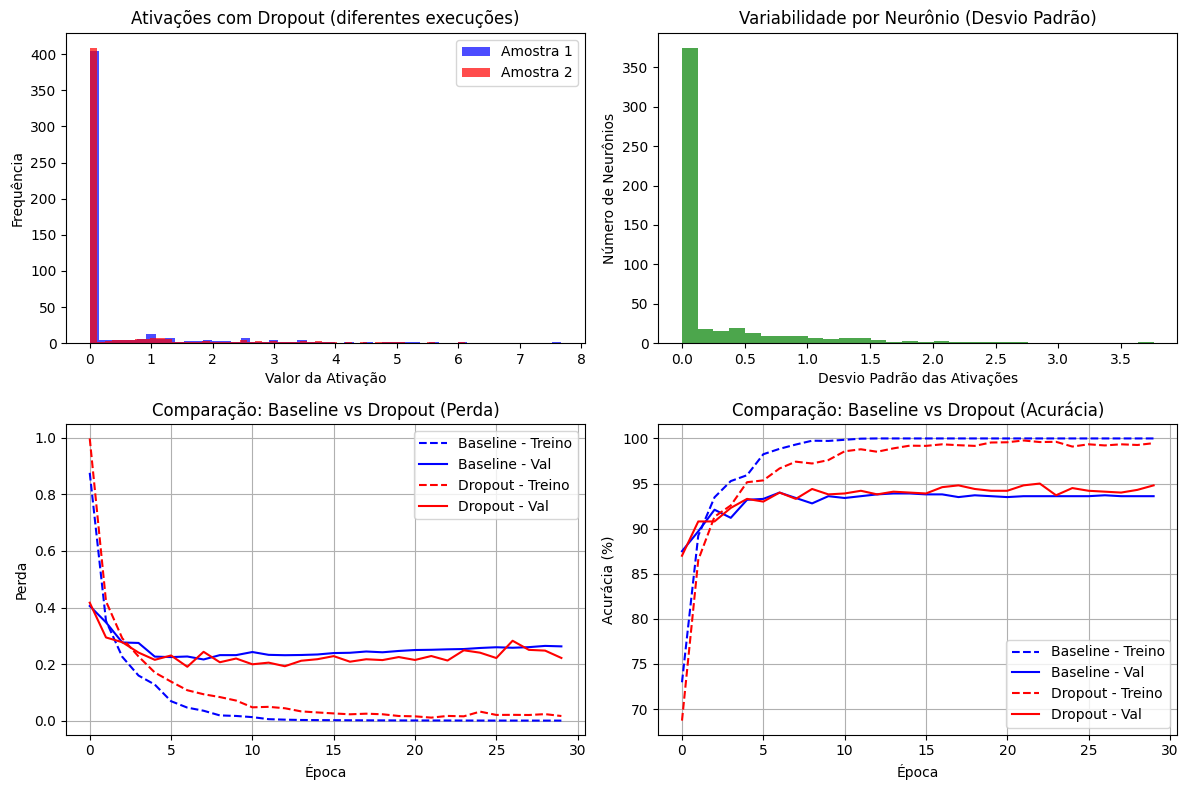


Desempenho do modelo com Dropout:
Acurácia de validação: 94.80%
Perda de validação: 0.2219


In [ ]:
# Visualização do efeito do dropout
def visualize_dropout_effect(model, input_tensor, num_samples=10):
    """Visualiza como o dropout afeta as ativações"""
    model.train()  # Ativar dropout

    activations = []
    for _ in range(num_samples):
        with torch.no_grad():
            x = model.flatten(input_tensor)
            x = F.relu(model.fc1(x))
            x = model.dropout1(x)  # Aplicar dropout
            activations.append(x.cpu().numpy())

    return np.array(activations)

# Pegar uma amostra do dataset
sample_data, _ = next(iter(val_loader))
sample = sample_data[0:1].to(device)  # Primeira amostra

# Comparar ativações com e sem dropout
dropout_activations = visualize_dropout_effect(dropout_model, sample)

# Plotar distribuição das ativações
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Ativações com dropout (múltiplas amostras)
axes[0, 0].hist(dropout_activations[0].flatten(), bins=50, alpha=0.7, color='blue', label='Amostra 1')
axes[0, 0].hist(dropout_activations[1].flatten(), bins=50, alpha=0.7, color='red', label='Amostra 2')
axes[0, 0].set_title('Ativações com Dropout (diferentes execuções)')
axes[0, 0].set_xlabel('Valor da Ativação')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()

# Comparação da variabilidade
std_per_neuron = np.std(dropout_activations, axis=0).flatten()
axes[0, 1].hist(std_per_neuron, bins=30, color='green', alpha=0.7)
axes[0, 1].set_title('Variabilidade por Neurônio (Desvio Padrão)')
axes[0, 1].set_xlabel('Desvio Padrão das Ativações')
axes[0, 1].set_ylabel('Número de Neurônios')

# Comparação das curvas de aprendizado
axes[1, 0].plot(baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
axes[1, 0].plot(baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
axes[1, 0].plot(dropout_train_losses, label='Dropout - Treino', color='red', linestyle='--')
axes[1, 0].plot(dropout_val_losses, label='Dropout - Val', color='red', linestyle='-')
axes[1, 0].set_title('Comparação: Baseline vs Dropout (Perda)')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Perda')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
axes[1, 1].plot(baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
axes[1, 1].plot(dropout_train_acc, label='Dropout - Treino', color='red', linestyle='--')
axes[1, 1].plot(dropout_val_acc, label='Dropout - Val', color='red', linestyle='-')
axes[1, 1].set_title('Comparação: Baseline vs Dropout (Acurácia)')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Acurácia (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

dropout_val_acc_final, dropout_val_loss_final = evaluate_model(dropout_model, val_loader)
print(f"\nDesempenho do modelo com Dropout:")
print(f"Acurácia de validação: {dropout_val_acc_final:.2f}%")
print(f"Perda de validação: {dropout_val_loss_final:.4f}")

## 3. Penalidades de Peso (L1 e L2)

As **penalidades de peso** adicionam um termo de regularização à função de custo original, penalizando pesos com magnitudes grandes. Isso encoraja o modelo a aprender representações mais simples.

### Regularização L2 (Weight Decay)

A regularização L2 adiciona o quadrado da magnitude dos pesos à função de custo:

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{original}} + \lambda \sum_{i} w_i^2$$

onde $\lambda$ é o coeficiente de regularização. O gradiente do termo de regularização é:

$$\frac{\partial}{\partial w_i}(\lambda w_i^2) = 2\lambda w_i$$

Isso leva à regra de atualização:

$$w_i \leftarrow w_i - \eta(\nabla \mathcal{L}_{\text{original}} + 2\lambda w_i) = (1 - 2\eta\lambda)w_i - \eta\nabla \mathcal{L}_{\text{original}}$$

### Regularização L1 (Lasso)

A regularização L1 adiciona a magnitude absoluta dos pesos:

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{original}} + \lambda \sum_{i} |w_i|$$

O gradiente (subgradiente) do termo L1 é:

$$\frac{\partial}{\partial w_i}(\lambda |w_i|) = \lambda \text{sign}(w_i)$$

A regularização L1 tende a produzir **sparsidade**, zerando muitos pesos.

In [ ]:
# Função de treinamento com penalidades L1 e L2
def train_model_with_penalties(model, train_loader, val_loader, criterion, optimizer,
                               l1_lambda=0, l2_lambda=0, num_epochs=10):
    """Treinamento com penalidades L1 e L2 explícitas"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Adicionar penalidades L1 e L2
            l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters()) if l1_lambda > 0 else 0
            l2_penalty = sum(torch.sum(p ** 2) for p in model.parameters()) if l2_lambda > 0 else 0

            total_loss = loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty

            total_loss.backward()
            optimizer.step()

            train_loss += loss.item()  # Apenas a perda original para comparação
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação (sem penalidades)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Experimento com regularização L2
l2_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(l2_model.parameters(), lr=0.001)

print("Treinando modelo com regularização L2 (lambda=0.01)...")
l2_train_losses, l2_val_losses, l2_train_acc, l2_val_acc = train_model_with_penalties(
    l2_model, train_loader, val_loader, criterion, optimizer,
    l1_lambda=0, l2_lambda=0.01, num_epochs=30
)

Treinando modelo com regularização L2 (lambda=0.01)...
Época [5/30] - Train Loss: 0.3024, Train Acc: 91.78% - Val Loss: 0.3350, Val Acc: 90.50%
Época [10/30] - Train Loss: 0.2176, Train Acc: 94.60% - Val Loss: 0.3413, Val Acc: 88.60%
Época [15/30] - Train Loss: 0.2209, Train Acc: 93.80% - Val Loss: 0.2901, Val Acc: 91.20%
Época [20/30] - Train Loss: 0.1951, Train Acc: 95.05% - Val Loss: 0.2808, Val Acc: 91.00%
Época [25/30] - Train Loss: 0.1866, Train Acc: 95.17% - Val Loss: 0.2554, Val Acc: 92.60%
Época [30/30] - Train Loss: 0.1644, Train Acc: 96.05% - Val Loss: 0.2526, Val Acc: 91.80%


In [ ]:
# Experimento com regularização L1
l1_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(l1_model.parameters(), lr=0.001)

print("Treinando modelo com regularização L1 (lambda=0.001)...")
l1_train_losses, l1_val_losses, l1_train_acc, l1_val_acc = train_model_with_penalties(
    l1_model, train_loader, val_loader, criterion, optimizer,
    l1_lambda=0.001, l2_lambda=0, num_epochs=30
)

Treinando modelo com regularização L1 (lambda=0.001)...
Época [5/30] - Train Loss: 0.4528, Train Acc: 88.22% - Val Loss: 0.4302, Val Acc: 88.10%
Época [10/30] - Train Loss: 0.3322, Train Acc: 91.08% - Val Loss: 0.3373, Val Acc: 89.50%
Época [15/30] - Train Loss: 0.2486, Train Acc: 93.40% - Val Loss: 0.2971, Val Acc: 91.00%
Época [20/30] - Train Loss: 0.2088, Train Acc: 94.50% - Val Loss: 0.2767, Val Acc: 91.30%
Época [25/30] - Train Loss: 0.1856, Train Acc: 95.38% - Val Loss: 0.2738, Val Acc: 91.50%
Época [30/30] - Train Loss: 0.1672, Train Acc: 96.05% - Val Loss: 0.2641, Val Acc: 91.20%


Baseline:
  Magnitude média: 0.023386
  Desvio padrão: 0.028946
  Sparsidade: 2.49%

L2 Regularization:
  Magnitude média: 0.003385
  Desvio padrão: 0.007863
  Sparsidade: 52.65%

L1 Regularization:
  Magnitude média: 0.000861
  Desvio padrão: 0.009423
  Sparsidade: 97.42%



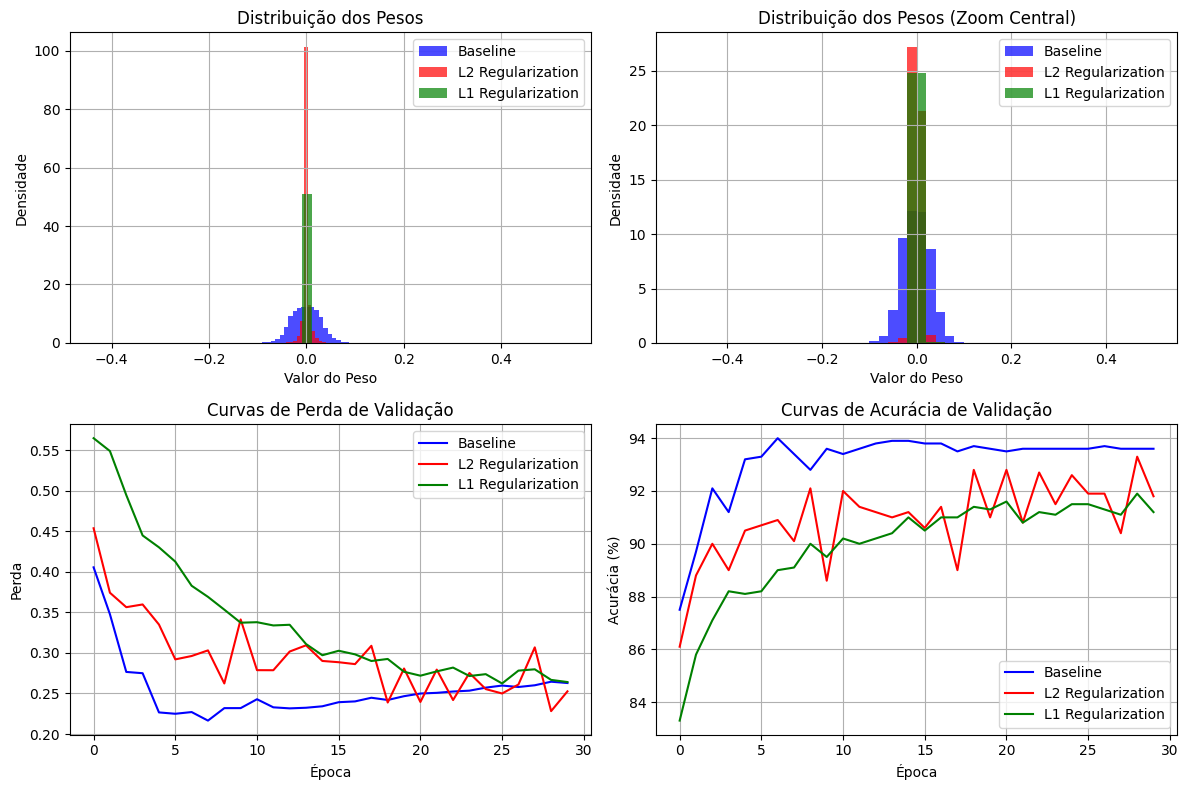

Desempenho final - Regularização L2:
Acurácia de validação: 91.80%
Perda de validação: 0.2526

Desempenho final - Regularização L1:
Acurácia de validação: 91.20%
Perda de validação: 0.2641


In [ ]:
# Análise da distribuição dos pesos
def plot_weight_distributions(models, labels, colors):
    """Plota a distribuição dos pesos de diferentes modelos"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for idx, (model, label, color) in enumerate(zip(models, labels, colors)):
        # Coletar todos os pesos do modelo
        all_weights = []
        for param in model.parameters():
            all_weights.extend(param.detach().cpu().numpy().flatten())

        all_weights = np.array(all_weights)

        # Histograma
        axes[0, 0].hist(all_weights, bins=50, alpha=0.7, label=label, color=color, density=True)

        # Estatísticas
        mean_weight = np.mean(np.abs(all_weights))
        std_weight = np.std(all_weights)
        sparsity = np.mean(np.abs(all_weights) < 1e-3) * 100  # Porcentagem de pesos "zero"

        print(f"{label}:")
        print(f"  Magnitude média: {mean_weight:.6f}")
        print(f"  Desvio padrão: {std_weight:.6f}")
        print(f"  Sparsidade: {sparsity:.2f}%")
        print()

    axes[0, 0].set_title('Distribuição dos Pesos')
    axes[0, 0].set_xlabel('Valor do Peso')
    axes[0, 0].set_ylabel('Densidade')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Zoom na região central
    for idx, (model, label, color) in enumerate(zip(models, labels, colors)):
        all_weights = []
        for param in model.parameters():
            all_weights.extend(param.detach().cpu().numpy().flatten())

        all_weights = np.array(all_weights)
        axes[0, 1].hist(all_weights, bins=50, alpha=0.7, label=label, color=color,
                       range=(-0.5, 0.5), density=True)

    axes[0, 1].set_title('Distribuição dos Pesos (Zoom Central)')
    axes[0, 1].set_xlabel('Valor do Peso')
    axes[0, 1].set_ylabel('Densidade')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Comparação das curvas de validação
    curves = [baseline_val_losses, l2_val_losses, l1_val_losses]
    for curve, label, color in zip(curves, labels, colors):
        axes[1, 0].plot(curve, label=label, color=color)

    axes[1, 0].set_title('Curvas de Perda de Validação')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Perda')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Comparação das curvas de acurácia
    curves = [baseline_val_acc, l2_val_acc, l1_val_acc]
    for curve, label, color in zip(curves, labels, colors):
        axes[1, 1].plot(curve, label=label, color=color)

    axes[1, 1].set_title('Curvas de Acurácia de Validação')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Acurácia (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plotar comparações
models = [baseline_model, l2_model, l1_model]
labels = ['Baseline', 'L2 Regularization', 'L1 Regularization']
colors = ['blue', 'red', 'green']

plot_weight_distributions(models, labels, colors)

# Avaliar desempenho final
l2_val_acc_final, l2_val_loss_final = evaluate_model(l2_model, val_loader)
l1_val_acc_final, l1_val_loss_final = evaluate_model(l1_model, val_loader)

print(f"Desempenho final - Regularização L2:")
print(f"Acurácia de validação: {l2_val_acc_final:.2f}%")
print(f"Perda de validação: {l2_val_loss_final:.4f}")
print()
print(f"Desempenho final - Regularização L1:")
print(f"Acurácia de validação: {l1_val_acc_final:.2f}%")
print(f"Perda de validação: {l1_val_loss_final:.4f}")

## 4. Early Stopping

O **Early Stopping** é uma técnica de regularização que interrompe o treinamento quando a performance no conjunto de validação para de melhorar, evitando que o modelo continue aprendendo padrões específicos dos dados de treino.

### Critérios de Parada

O early stopping monitora uma métrica de validação $V(t)$ (como perda ou acurácia) ao longo das épocas $t$. O treinamento é interrompido quando:

$$V(t) > V(t-p) + \delta$$

onde:
- $p$ é a **paciência** (número de épocas sem melhoria)
- $\delta$ é a **tolerância mínima** de melhoria

Esta técnica implementa implicitamente a regularização ao limitar a capacidade do modelo de se ajustar excessivamente aos dados de treino.

In [ ]:
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                             patience=5, min_delta=0.001, max_epochs=50):
    """Treinamento com early stopping"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(max_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        # Verificar early stopping
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{max_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}% - '
                  f'Paciência: {epochs_without_improvement}/{patience}')

        # Parar se a paciência se esgotou
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping na época {epoch + 1}")
            print(f"Melhor perda de validação: {best_val_loss:.4f}")
            break

    # Restaurar o melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Modelo restaurado para o melhor estado")

    return train_losses, val_losses, train_accuracies, val_accuracies, epoch + 1

Treinando modelo com Early Stopping (paciência=7)...
Época [5/50] - Train Loss: 0.1090, Train Acc: 96.65% - Val Loss: 0.2264, Val Acc: 92.90% - Paciência: 0/7
Época [10/50] - Train Loss: 0.0125, Train Acc: 99.78% - Val Loss: 0.2139, Val Acc: 93.80% - Paciência: 0/7
Época [15/50] - Train Loss: 0.0023, Train Acc: 100.00% - Val Loss: 0.2317, Val Acc: 94.00% - Paciência: 5/7

Early stopping na época 17
Melhor perda de validação: 0.2139
Modelo restaurado para o melhor estado


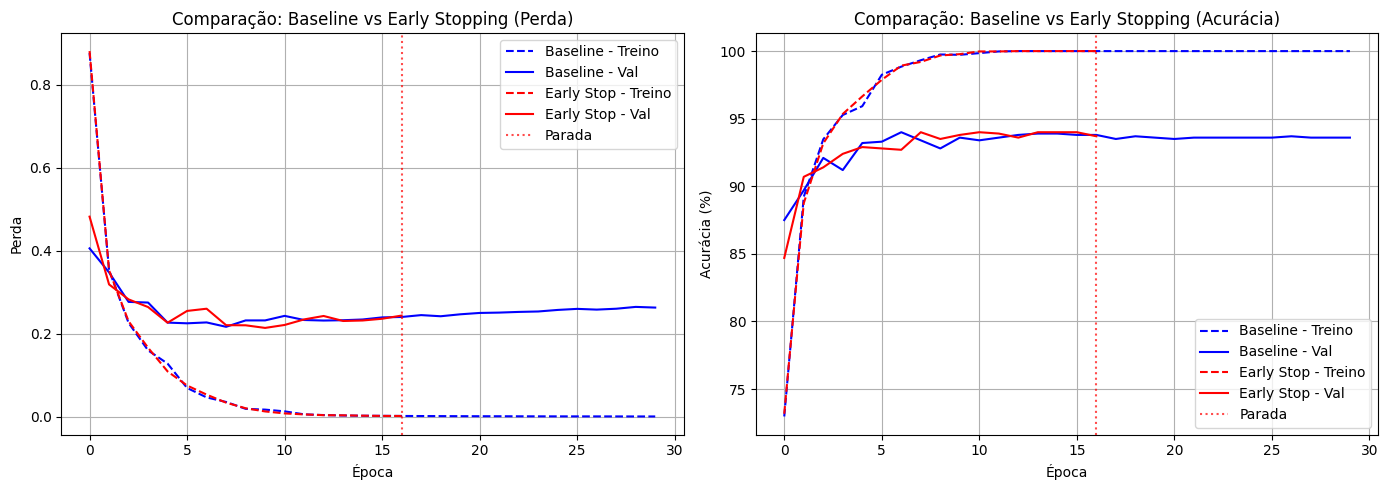


Desempenho do modelo com Early Stopping:
Acurácia de validação: 93.80%
Perda de validação: 0.2139
Épocas treinadas: 17


In [ ]:
# Experimento com early stopping
early_stop_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(early_stop_model.parameters(), lr=0.001)

print("Treinando modelo com Early Stopping (paciência=7)...")
es_train_losses, es_val_losses, es_train_acc, es_val_acc, final_epoch = train_with_early_stopping(
    early_stop_model, train_loader, val_loader, criterion, optimizer,
    patience=7, min_delta=0.001, max_epochs=50
)

# Plotar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Comparação das perdas
epochs_baseline = range(len(baseline_train_losses))
epochs_es = range(len(es_train_losses))

ax1.plot(epochs_baseline, baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
ax1.plot(epochs_baseline, baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
ax1.plot(epochs_es, es_train_losses, label='Early Stop - Treino', color='red', linestyle='--')
ax1.plot(epochs_es, es_val_losses, label='Early Stop - Val', color='red', linestyle='-')
ax1.axvline(x=final_epoch-1, color='red', linestyle=':', alpha=0.7, label='Parada')
ax1.set_title('Comparação: Baseline vs Early Stopping (Perda)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Comparação das acurácias
ax2.plot(epochs_baseline, baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
ax2.plot(epochs_baseline, baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
ax2.plot(epochs_es, es_train_acc, label='Early Stop - Treino', color='red', linestyle='--')
ax2.plot(epochs_es, es_val_acc, label='Early Stop - Val', color='red', linestyle='-')
ax2.axvline(x=final_epoch-1, color='red', linestyle=':', alpha=0.7, label='Parada')
ax2.set_title('Comparação: Baseline vs Early Stopping (Acurácia)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

es_val_acc_final, es_val_loss_final = evaluate_model(early_stop_model, val_loader)
print(f"\nDesempenho do modelo com Early Stopping:")
print(f"Acurácia de validação: {es_val_acc_final:.2f}%")
print(f"Perda de validação: {es_val_loss_final:.4f}")
print(f"Épocas treinadas: {final_epoch}")

## 5. Data Augmentation

O **Data Augmentation** é uma técnica que artificialmente aumenta o tamanho do dataset através de transformações que preservam a classe dos dados. Para imagens, isso inclui rotações, translações, mudanças de brilho, etc.

### Fundamentação Teórica

Data augmentation implementa uma forma de regularização ao expor o modelo a variações realísticas dos dados de treino. Matematicamente, se $\mathcal{T}$ é um conjunto de transformações válidas, então para cada amostra $(x, y)$, geramos:

$$\{(T(x), y) : T \in \mathcal{T}\}$$

Isso efetivamente aumenta o tamanho do dataset de $N$ para $N \times |\mathcal{T}|$ amostras, melhorando a capacidade de generalização.

### Invariâncias

O data augmentation ensina ao modelo **invariâncias importantes**:
- **Invariância translacional**: o objeto continua o mesmo independente da posição
- **Invariância rotacional**: pequenas rotações não alteram a classe
- **Invariância de iluminação**: mudanças de brilho não afetam a identidade

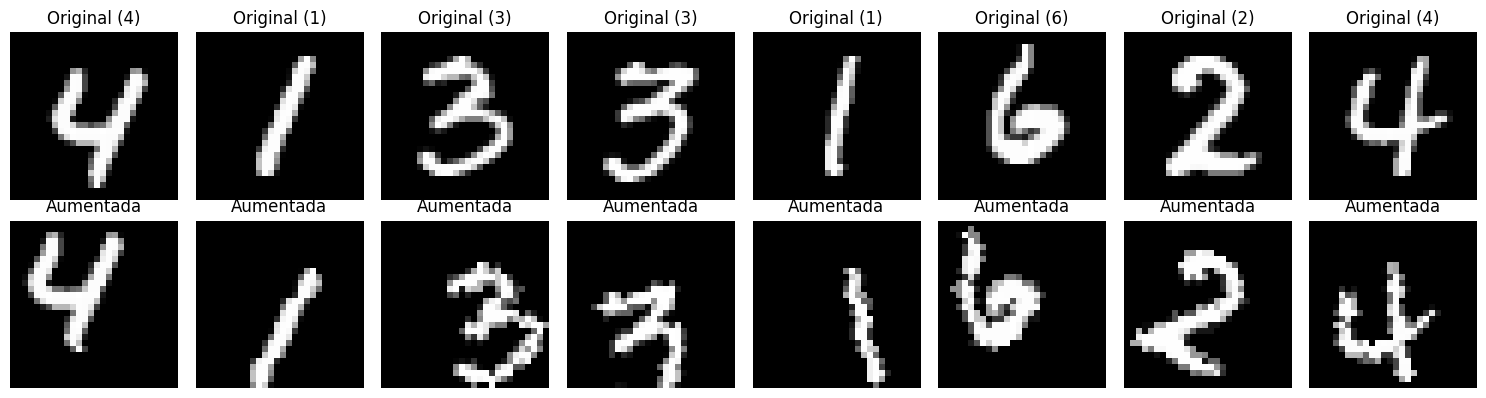

In [ ]:
# Definindo transformações de data augmentation
train_transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),  # Rotação aleatória de até 10 graus
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),  # Translação aleatória
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset com data augmentation
train_dataset_augmented = torchvision.datasets.MNIST(
    root='./data', train=True, transform=train_transform_augmented, download=False
)
train_dataset_augmented = Subset(train_dataset_augmented, train_indices)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Visualizar algumas amostras aumentadas
def show_augmented_samples(dataset, original_dataset, num_samples=8):
    """Mostra comparação entre amostras originais e aumentadas"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

    # Escolher índices aleatórios
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Amostra original
        orig_img, label = original_dataset[idx]
        orig_img = orig_img * 0.3081 + 0.1307  # Desnormalizar

        # Amostra aumentada
        aug_img, _ = dataset[idx]
        aug_img = aug_img * 0.3081 + 0.1307  # Desnormalizar

        axes[0, i].imshow(orig_img.squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original ({label})')
        axes[0, i].axis('off')

        axes[1, i].imshow(aug_img.squeeze(), cmap='gray')
        axes[1, i].set_title('Aumentada')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_samples(train_dataset_augmented, train_dataset)

Treinando modelo com Data Augmentation...
Época [5/30] - Train Loss: 0.9075, Train Acc: 70.78% - Val Loss: 0.4582, Val Acc: 87.70%
Época [10/30] - Train Loss: 0.5906, Train Acc: 81.28% - Val Loss: 0.3016, Val Acc: 91.40%
Época [15/30] - Train Loss: 0.5316, Train Acc: 83.65% - Val Loss: 0.2785, Val Acc: 91.70%
Época [20/30] - Train Loss: 0.4441, Train Acc: 85.55% - Val Loss: 0.2139, Val Acc: 93.20%
Época [25/30] - Train Loss: 0.3947, Train Acc: 87.10% - Val Loss: 0.1484, Val Acc: 95.20%
Época [30/30] - Train Loss: 0.3836, Train Acc: 87.47% - Val Loss: 0.1848, Val Acc: 93.40%


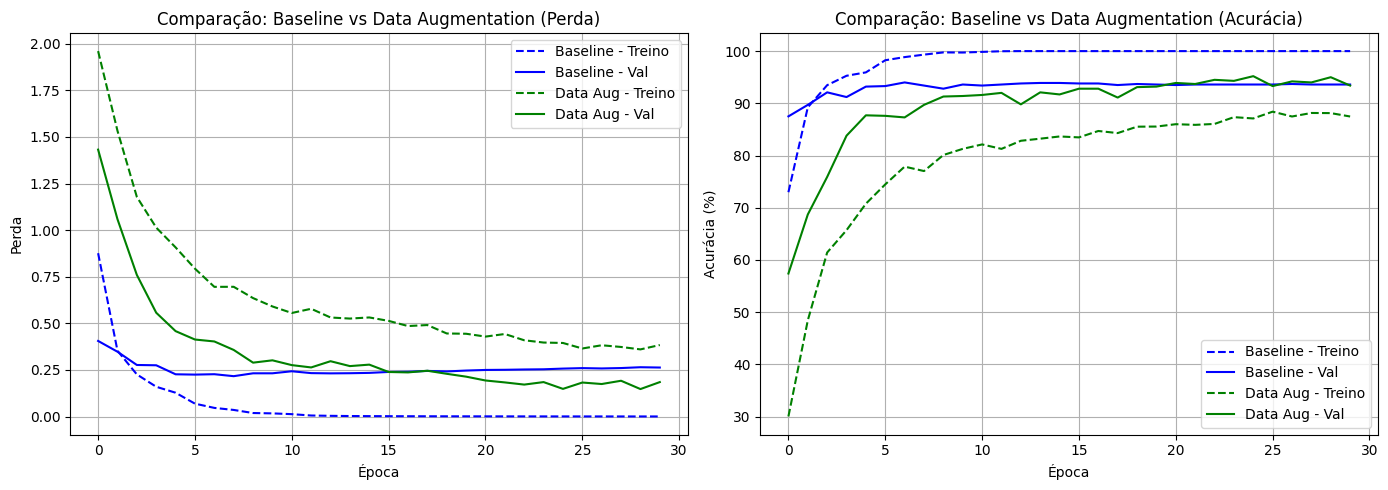


Desempenho do modelo com Data Augmentation:
Acurácia de validação: 93.40%
Perda de validação: 0.1848


In [ ]:
# Experimento com data augmentation
aug_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.001)

print("Treinando modelo com Data Augmentation...")
aug_train_losses, aug_val_losses, aug_train_acc, aug_val_acc = train_model(
    aug_model, train_loader_augmented, val_loader, criterion, optimizer, num_epochs=30
)

# Plotar comparação
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Comparação das perdas
ax1.plot(baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
ax1.plot(baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
ax1.plot(aug_train_losses, label='Data Aug - Treino', color='green', linestyle='--')
ax1.plot(aug_val_losses, label='Data Aug - Val', color='green', linestyle='-')
ax1.set_title('Comparação: Baseline vs Data Augmentation (Perda)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Comparação das acurácias
ax2.plot(baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
ax2.plot(baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
ax2.plot(aug_train_acc, label='Data Aug - Treino', color='green', linestyle='--')
ax2.plot(aug_val_acc, label='Data Aug - Val', color='green', linestyle='-')
ax2.set_title('Comparação: Baseline vs Data Augmentation (Acurácia)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

aug_val_acc_final, aug_val_loss_final = evaluate_model(aug_model, val_loader)
print(f"\nDesempenho do modelo com Data Augmentation:")
print(f"Acurácia de validação: {aug_val_acc_final:.2f}%")
print(f"Perda de validação: {aug_val_loss_final:.4f}")

## Conclusões

1. **Dropout**: Eficaz e fácil de implementar. Funciona bem em redes totalmente conectadas e pode ser ajustado via taxa de dropout.

2. **Regularização L2 (Weight Decay)**: Suaviza os pesos, prevenindo valores extremos. Amplamente usado e computacionalmente eficiente.

3. **Regularização L1**: Promove sparsidade, útil para seleção automática de features. Pode ser mais difícil de otimizar.

4. **Early Stopping**: Simples e efetivo, mas requer conjunto de validação separado e monitoramento cuidadoso.

5. **Data Augmentation**: Especialmente poderoso para dados visuais, mas requer conhecimento do domínio para escolher transformações apropriadas.

## Exercícios

### Exercício 1: Experimentação com Hyperparâmetros
Teste diferentes valores de dropout rate e compare os resultados. Qual valor funciona melhor para este dataset?

### Exercício 2: Combinação de Técnicas
Crie um modelo que combine dropout com regularização L2. Compare com os modelos individuais.

### Exercício 3: Data Augmentation Customizado
Experimente diferentes transformações de data augmentation (veja a documentação do TorchVision).

### Exercício 4: Análise de Overfitting
Use um dataset ainda menor (1000 amostras de treino) e compare como cada técnica de regularização se comporta em um cenário de overfitting mais severo.

Experimentando com diferentes taxas de dropout...

Treinando com dropout rate = 0.1
Época [5/30] - Train Loss: 0.1438, Train Acc: 95.80% - Val Loss: 0.2841, Val Acc: 91.70%
Época [10/30] - Train Loss: 0.0257, Train Acc: 99.45% - Val Loss: 0.2317, Val Acc: 93.70%
Época [15/30] - Train Loss: 0.0079, Train Acc: 99.92% - Val Loss: 0.2668, Val Acc: 93.20%
Época [20/30] - Train Loss: 0.0072, Train Acc: 99.85% - Val Loss: 0.2501, Val Acc: 94.20%
Época [25/30] - Train Loss: 0.0043, Train Acc: 99.92% - Val Loss: 0.2611, Val Acc: 94.70%
Época [30/30] - Train Loss: 0.0114, Train Acc: 99.62% - Val Loss: 0.2714, Val Acc: 94.30%


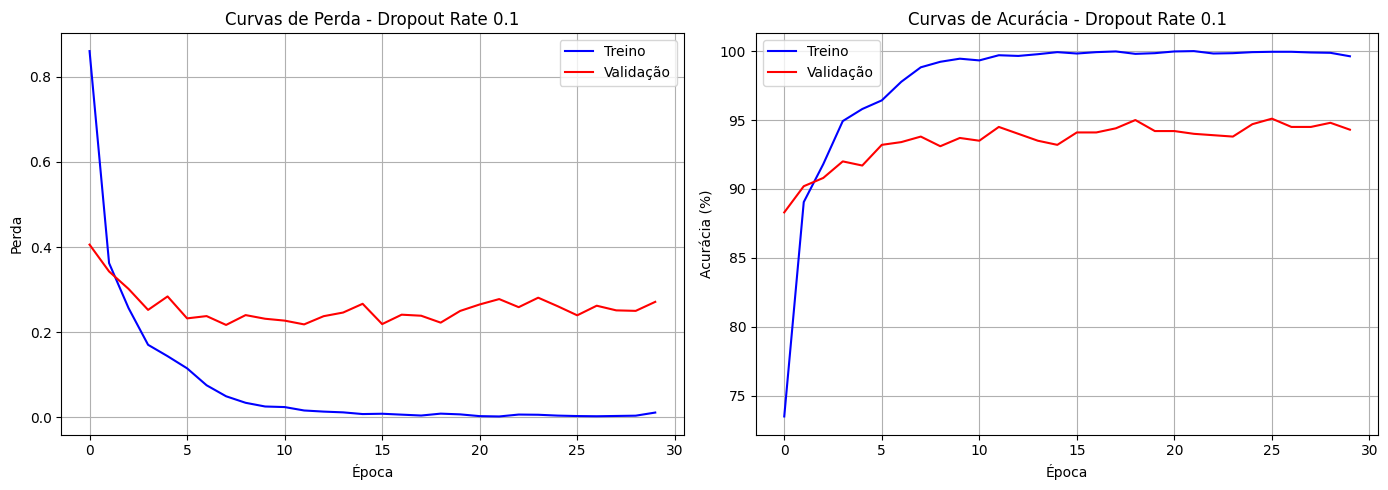


Treinando com dropout rate = 0.5
Época [5/30] - Train Loss: 0.2525, Train Acc: 92.25% - Val Loss: 0.2345, Val Acc: 93.00%
Época [10/30] - Train Loss: 0.1308, Train Acc: 95.47% - Val Loss: 0.2135, Val Acc: 93.50%
Época [15/30] - Train Loss: 0.0787, Train Acc: 97.25% - Val Loss: 0.2320, Val Acc: 94.20%
Época [20/30] - Train Loss: 0.0630, Train Acc: 97.85% - Val Loss: 0.2089, Val Acc: 94.20%
Época [25/30] - Train Loss: 0.0551, Train Acc: 98.42% - Val Loss: 0.2298, Val Acc: 94.50%
Época [30/30] - Train Loss: 0.0373, Train Acc: 98.85% - Val Loss: 0.1904, Val Acc: 94.70%


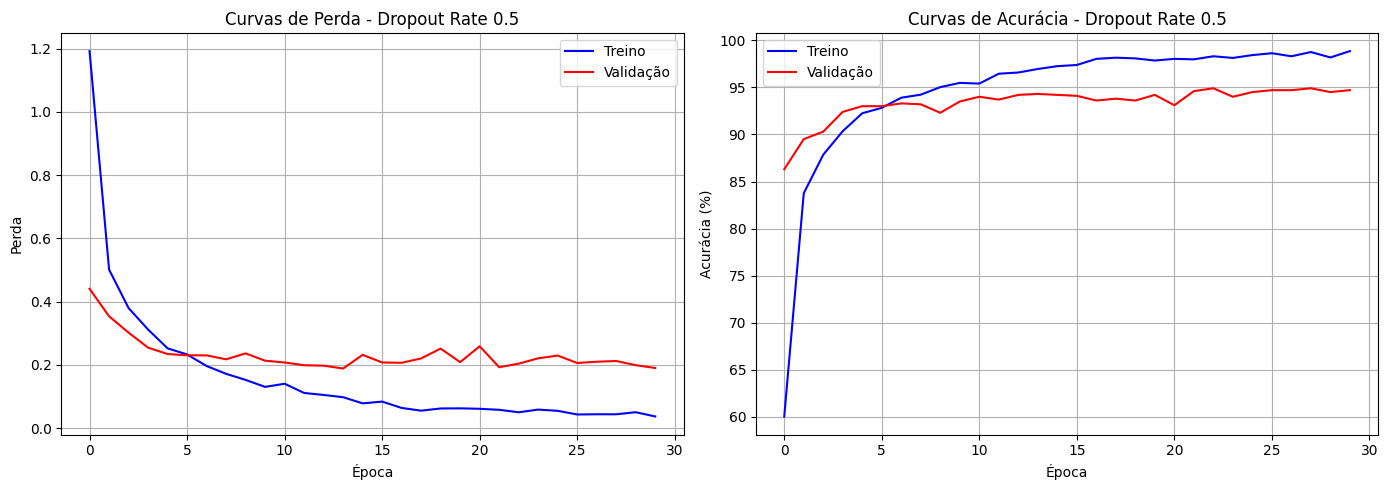


Treinando com dropout rate = 0.7
Época [5/30] - Train Loss: 0.4765, Train Acc: 84.62% - Val Loss: 0.3085, Val Acc: 90.00%
Época [10/30] - Train Loss: 0.3370, Train Acc: 89.25% - Val Loss: 0.2515, Val Acc: 92.70%
Época [15/30] - Train Loss: 0.2442, Train Acc: 92.22% - Val Loss: 0.2551, Val Acc: 92.70%
Época [20/30] - Train Loss: 0.2131, Train Acc: 93.40% - Val Loss: 0.2225, Val Acc: 93.60%
Época [25/30] - Train Loss: 0.1557, Train Acc: 95.08% - Val Loss: 0.2372, Val Acc: 94.30%
Época [30/30] - Train Loss: 0.1463, Train Acc: 95.35% - Val Loss: 0.2395, Val Acc: 93.20%


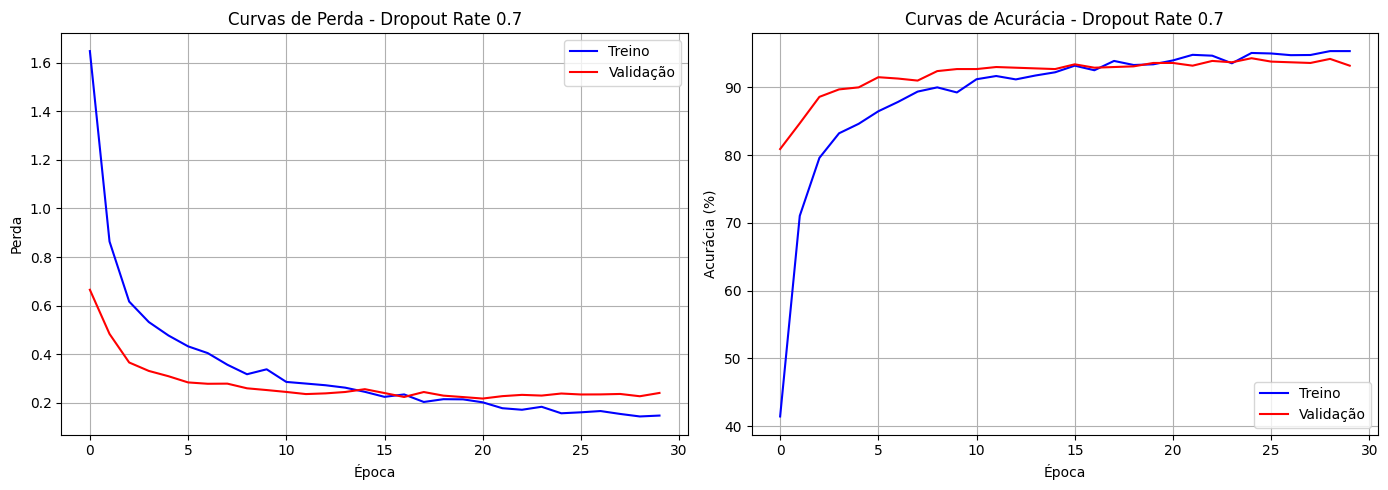


Resultados finais por taxa de dropout:
Dropout Rate 0.1: Acurácia de validação = 94.30%, Perda de validação = 0.2714
Dropout Rate 0.5: Acurácia de validação = 94.70%, Perda de validação = 0.1904
Dropout Rate 0.7: Acurácia de validação = 93.20%, Perda de validação = 0.2395


In [ ]:
# Exercício 1: Experimentação com Hyperparâmetros
dropout_rates = [0.1, 0.5, 0.7]
results = {}

print("Experimentando com diferentes taxas de dropout...")

for rate in dropout_rates:
    print(f"\nTreinando com dropout rate = {rate}")
    dropout_model_exp = BaseModel(dropout_rate=rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(dropout_model_exp.parameters(), lr=0.001)

    train_losses, val_losses, train_acc, val_acc = train_model(
        dropout_model_exp, train_loader, val_loader, criterion, optimizer, num_epochs=30
    )

    final_val_acc, final_val_loss = evaluate_model(dropout_model_exp, val_loader)
    results[rate] = {'val_acc': final_val_acc, 'val_loss': final_val_loss}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(train_losses, label='Treino', color='blue')
    ax1.plot(val_losses, label='Validação', color='red')
    ax1.set_title(f'Curvas de Perda - Dropout Rate {rate}')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_acc, label='Treino', color='blue')
    ax2.plot(val_acc, label='Validação', color='red')
    ax2.set_title(f'Curvas de Acurácia - Dropout Rate {rate}')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Acurácia (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("\nResultados finais por taxa de dropout:")
for rate, metrics in results.items():
    print(f"Dropout Rate {rate}: Acurácia de validação = {metrics['val_acc']:.2f}%, Perda de validação = {metrics['val_loss']:.4f}")

Treinando modelo com Dropout (0.3) + Regularização L2 (0.01)...
Época [5/30] - Train Loss: 0.3410, Train Acc: 90.08% - Val Loss: 0.3102, Val Acc: 92.00%
Época [10/30] - Train Loss: 0.2664, Train Acc: 92.50% - Val Loss: 0.2792, Val Acc: 91.30%
Época [15/30] - Train Loss: 0.2619, Train Acc: 92.88% - Val Loss: 0.2585, Val Acc: 92.30%
Época [20/30] - Train Loss: 0.2377, Train Acc: 93.55% - Val Loss: 0.2496, Val Acc: 91.80%
Época [25/30] - Train Loss: 0.2320, Train Acc: 93.92% - Val Loss: 0.2491, Val Acc: 92.40%
Época [30/30] - Train Loss: 0.2417, Train Acc: 92.92% - Val Loss: 0.2742, Val Acc: 91.10%


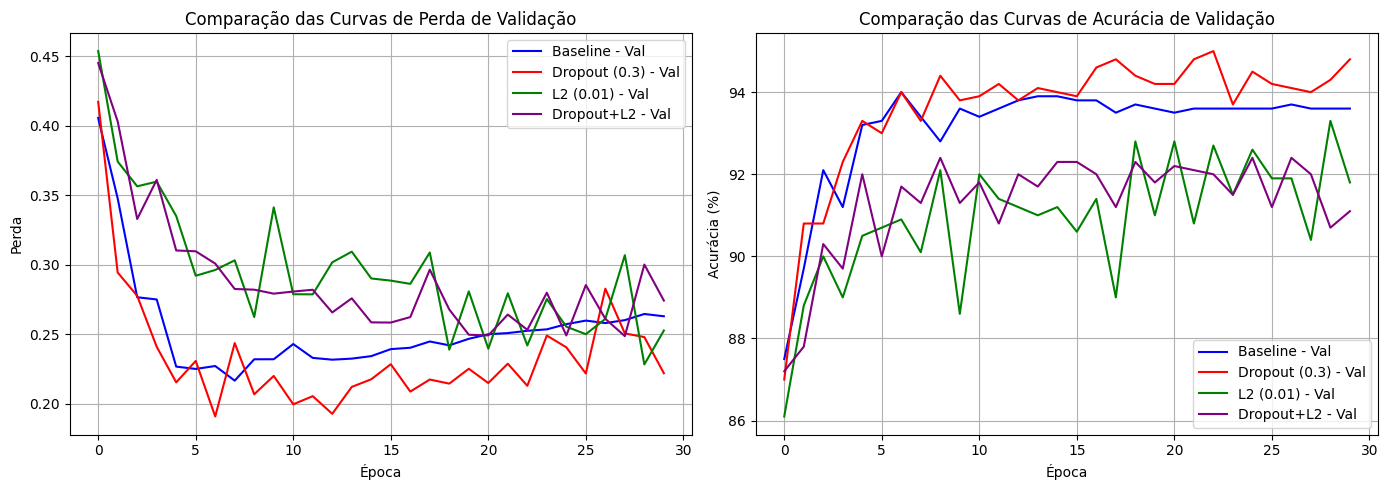


Desempenho final do modelo combinado (Dropout+L2):
Acurácia de validação: 91.10%
Perda de validação: 0.2742


In [ ]:
# Exercício 2: Combinação de Técnicas
combined_model = BaseModel(dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.001)

print("Treinando modelo com Dropout (0.3) + Regularização L2 (0.01)...")
combined_train_losses, combined_val_losses, combined_train_acc, combined_val_acc = train_model_with_penalties(
    combined_model, train_loader, val_loader, criterion, optimizer,
    l1_lambda=0, l2_lambda=0.01, num_epochs=30
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
ax1.plot(dropout_val_losses, label='Dropout (0.3) - Val', color='red', linestyle='-')
ax1.plot(l2_val_losses, label='L2 (0.01) - Val', color='green', linestyle='-')
ax1.plot(combined_val_losses, label='Dropout+L2 - Val', color='purple', linestyle='-')
ax1.set_title('Comparação das Curvas de Perda de Validação')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

ax2.plot(baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
ax2.plot(dropout_val_acc, label='Dropout (0.3) - Val', color='red', linestyle='-')
ax2.plot(l2_val_acc, label='L2 (0.01) - Val', color='green', linestyle='-')
ax2.plot(combined_val_acc, label='Dropout+L2 - Val', color='purple', linestyle='-')
ax2.set_title('Comparação das Curvas de Acurácia de Validação')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

combined_val_acc_final, combined_val_loss_final = evaluate_model(combined_model, val_loader)
print(f"\nDesempenho final do modelo combinado (Dropout+L2):")
print(f"Acurácia de validação: {combined_val_acc_final:.2f}%")
print(f"Perda de validação: {combined_val_loss_final:.4f}")

Visualizando algumas amostras com data augmentation customizado...


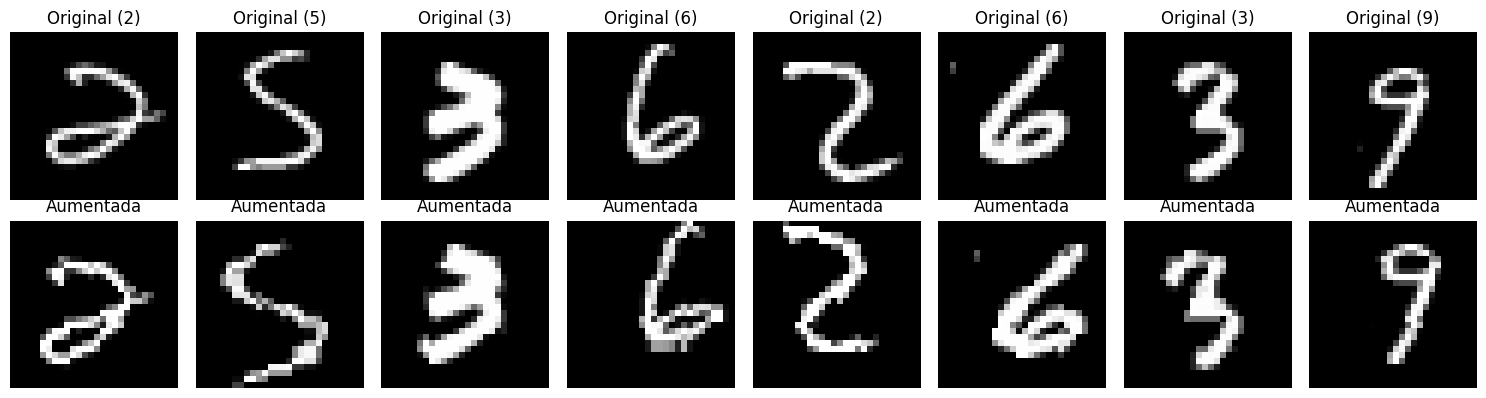

Treinando modelo com Data Augmentation Customizado...
Época [5/30] - Train Loss: 0.4695, Train Acc: 85.03% - Val Loss: 0.2113, Val Acc: 94.10%
Época [10/30] - Train Loss: 0.3151, Train Acc: 89.33% - Val Loss: 0.1450, Val Acc: 95.10%
Época [15/30] - Train Loss: 0.2534, Train Acc: 91.90% - Val Loss: 0.1253, Val Acc: 96.30%
Época [20/30] - Train Loss: 0.2097, Train Acc: 93.17% - Val Loss: 0.1105, Val Acc: 96.20%
Época [25/30] - Train Loss: 0.1905, Train Acc: 94.28% - Val Loss: 0.0722, Val Acc: 97.50%
Época [30/30] - Train Loss: 0.1654, Train Acc: 94.80% - Val Loss: 0.0858, Val Acc: 97.60%


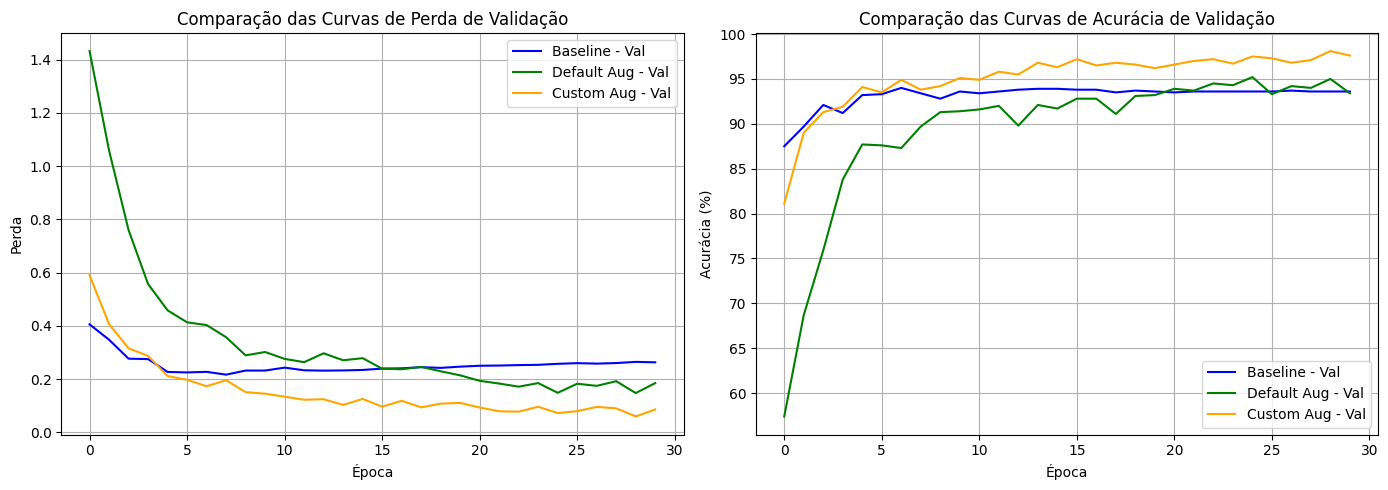


Desempenho do modelo com Data Augmentation Customizado:
Acurácia de validação: 97.60%
Perda de validação: 0.0858


In [ ]:
# Exercício 3: Data Augmentation Customizado
train_transform_custom_aug = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset_custom_aug = torchvision.datasets.MNIST(
    root='./data', train=True, transform=train_transform_custom_aug, download=False
)
train_dataset_custom_aug = Subset(train_dataset_custom_aug, train_indices)
train_loader_custom_aug = DataLoader(train_dataset_custom_aug, batch_size=batch_size, shuffle=True)

print("Visualizando algumas amostras com data augmentation customizado...")
show_augmented_samples(train_dataset_custom_aug, train_dataset)

custom_aug_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_aug_model.parameters(), lr=0.001)

print("Treinando modelo com Data Augmentation Customizado...")
custom_aug_train_losses, custom_aug_val_losses, custom_aug_train_acc, custom_aug_val_acc = train_model(
    custom_aug_model, train_loader_custom_aug, val_loader, criterion, optimizer, num_epochs=30
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
ax1.plot(aug_val_losses, label='Default Aug - Val', color='green', linestyle='-')
ax1.plot(custom_aug_val_losses, label='Custom Aug - Val', color='orange', linestyle='-')
ax1.set_title('Comparação das Curvas de Perda de Validação')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

ax2.plot(baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
ax2.plot(aug_val_acc, label='Default Aug - Val', color='green', linestyle='-')
ax2.plot(custom_aug_val_acc, label='Custom Aug - Val', color='orange', linestyle='-')
ax2.set_title('Comparação das Curvas de Acurácia de Validação')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

custom_aug_val_acc_final, custom_aug_val_loss_final = evaluate_model(custom_aug_model, val_loader)
print(f"\nDesempenho do modelo com Data Augmentation Customizado:")
print(f"Acurácia de validação: {custom_aug_val_acc_final:.2f}%")
print(f"Perda de validação: {custom_aug_val_loss_final:.4f}")

Treinando modelos com dataset de treino reduzido (1000 amostras)...

Treinando modelo baseline (dataset menor)...
Época [5/30] - Train Loss: 0.1944, Train Acc: 94.40% - Val Loss: 0.3982, Val Acc: 87.20%
Época [10/30] - Train Loss: 0.0351, Train Acc: 99.80% - Val Loss: 0.3883, Val Acc: 89.50%
Época [15/30] - Train Loss: 0.0089, Train Acc: 100.00% - Val Loss: 0.4114, Val Acc: 89.20%
Época [20/30] - Train Loss: 0.0041, Train Acc: 100.00% - Val Loss: 0.4267, Val Acc: 89.80%
Época [25/30] - Train Loss: 0.0024, Train Acc: 100.00% - Val Loss: 0.4445, Val Acc: 89.50%
Época [30/30] - Train Loss: 0.0017, Train Acc: 100.00% - Val Loss: 0.4561, Val Acc: 90.00%

Treinando modelo com Dropout (0.3) (dataset menor)...
Época [5/30] - Train Loss: 0.2878, Train Acc: 90.60% - Val Loss: 0.4097, Val Acc: 88.20%
Época [10/30] - Train Loss: 0.1037, Train Acc: 96.80% - Val Loss: 0.3752, Val Acc: 89.00%
Época [15/30] - Train Loss: 0.0367, Train Acc: 99.40% - Val Loss: 0.3692, Val Acc: 89.80%
Época [20/30] - Tra

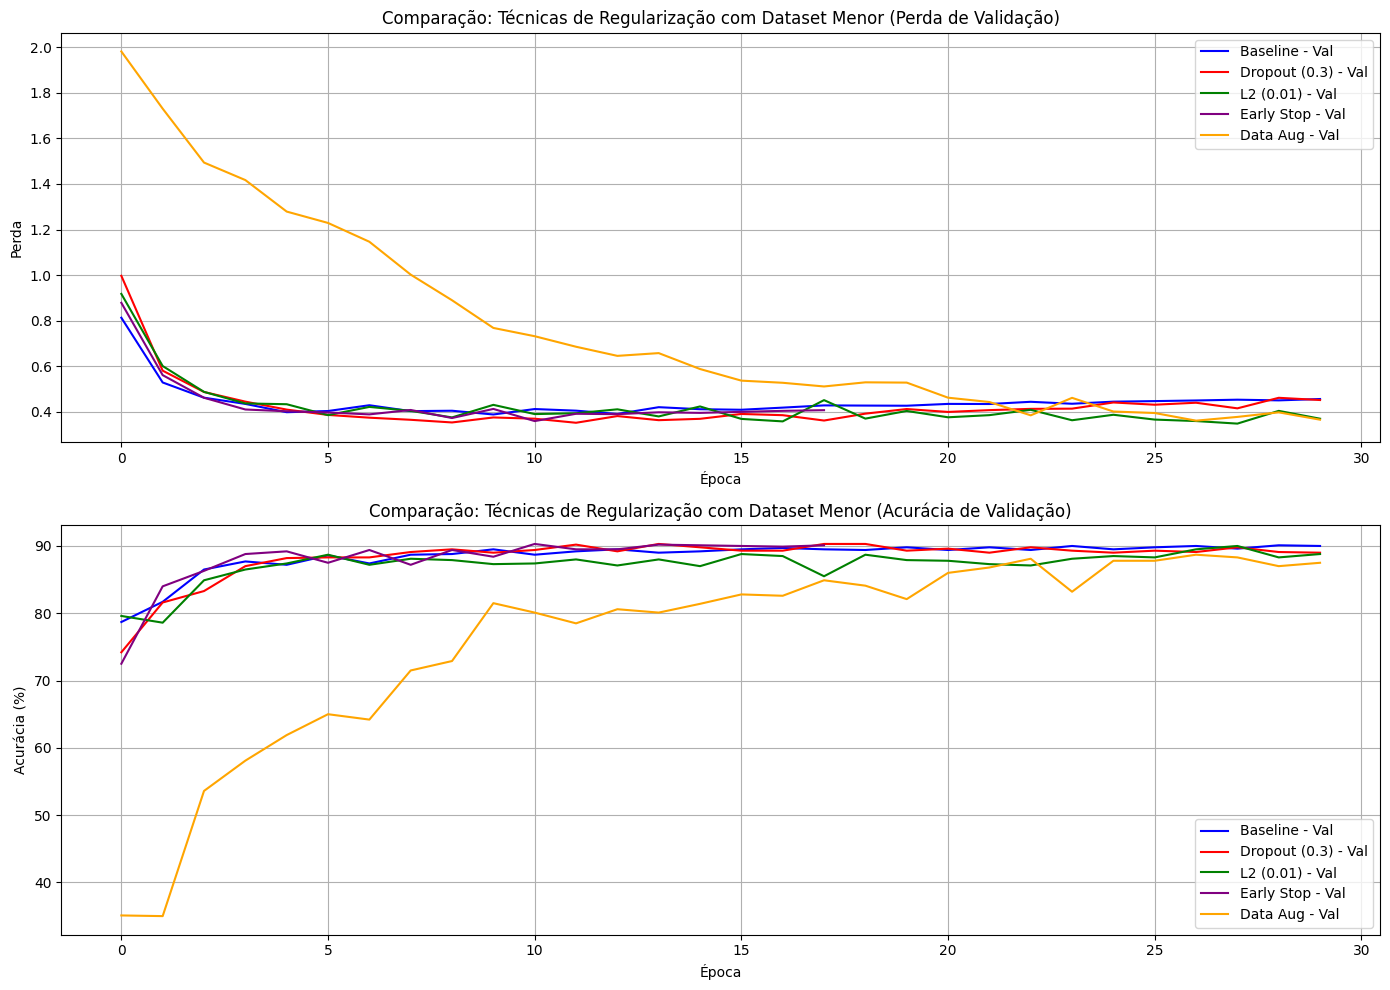

In [ ]:
# Exercício 4: Análise de Overfitting com Dataset Menor
small_train_indices = torch.randperm(len(full_train_dataset))[:1000]
small_train_dataset = Subset(full_train_dataset, small_train_indices)
small_train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)

print("Treinando modelos com dataset de treino reduzido (1000 amostras)...")

# Baseline com dataset menor
small_baseline_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_baseline_model.parameters(), lr=0.001)

print("\nTreinando modelo baseline (dataset menor)...")
small_baseline_train_losses, small_baseline_val_losses, small_baseline_train_acc, small_baseline_val_acc = train_model(
    small_baseline_model, small_train_loader, val_loader, criterion, optimizer, num_epochs=30
)

# Dropout com dataset menor
small_dropout_model = BaseModel(dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_dropout_model.parameters(), lr=0.001)

print("\nTreinando modelo com Dropout (0.3) (dataset menor)...")
small_dropout_train_losses, small_dropout_val_losses, small_dropout_train_acc, small_dropout_val_acc = train_model(
    small_dropout_model, small_train_loader, val_loader, criterion, optimizer, num_epochs=30
)

# L2 com dataset menor
small_l2_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_l2_model.parameters(), lr=0.001)

print("\nTreinando modelo com L2 (0.01) (dataset menor)...")
small_l2_train_losses, small_l2_val_losses, small_l2_train_acc, small_l2_val_acc = train_model_with_penalties(
    small_l2_model, small_train_loader, val_loader, criterion, optimizer,
    l1_lambda=0, l2_lambda=0.01, num_epochs=30
)

# Early Stopping com dataset menor
small_early_stop_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_early_stop_model.parameters(), lr=0.001)

print("\nTreinando modelo com Early Stopping (paciência=7) (dataset menor)...")
small_es_train_losses, small_es_val_losses, small_es_train_acc, small_es_val_acc, small_final_epoch = train_with_early_stopping(
    small_early_stop_model, small_train_loader, val_loader, criterion, optimizer,
    patience=7, min_delta=0.001, max_epochs=50
)


# Data Augmentation com dataset menor
small_train_transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

small_train_dataset_augmented = torchvision.datasets.MNIST(
    root='./data', train=True, transform=small_train_transform_augmented, download=False
)
small_train_dataset_augmented = Subset(small_train_dataset_augmented, small_train_indices)
small_train_loader_augmented = DataLoader(small_train_dataset_augmented, batch_size=batch_size, shuffle=True)

small_aug_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(small_aug_model.parameters(), lr=0.001)

print("\nTreinando modelo com Data Augmentation (dataset menor)...")
small_aug_train_losses, small_aug_val_losses, small_aug_train_acc, small_aug_val_acc = train_model(
    small_aug_model, small_train_loader_augmented, val_loader, criterion, optimizer, num_epochs=30
)

# Plotar comparação
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(small_baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
axes[0].plot(small_dropout_val_losses, label='Dropout (0.3) - Val', color='red', linestyle='-')
axes[0].plot(small_l2_val_losses, label='L2 (0.01) - Val', color='green', linestyle='-')
axes[0].plot(small_es_val_losses, label='Early Stop - Val', color='purple', linestyle='-')
axes[0].plot(small_aug_val_losses, label='Data Aug - Val', color='orange', linestyle='-')
axes[0].set_title('Comparação: Técnicas de Regularização com Dataset Menor (Perda de Validação)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Perda')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(small_baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
axes[1].plot(small_dropout_val_acc, label='Dropout (0.3) - Val', color='red', linestyle='-')
axes[1].plot(small_l2_val_acc, label='L2 (0.01) - Val', color='green', linestyle='-')
axes[1].plot(small_es_val_acc, label='Early Stop - Val', color='purple', linestyle='-')
axes[1].plot(small_aug_val_acc, label='Data Aug - Val', color='orange', linestyle='-')
axes[1].set_title('Comparação: Técnicas de Regularização com Dataset Menor (Acurácia de Validação)')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia (%)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()